setting up

In [0]:
from keras.optimizers import Adam
import numpy as np

np.random.seed(10)

noise_dim = 100

batch_size = 16
steps_per_epoch = 3750  # batch_size * steps_per_epoch = epoch size (train size)
epochs = 20

img_rows, img_cols, channels = 28, 28, 1

optimizer = Adam(0.0002, 0.5)

import data set

In [13]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1

x_train = x_train.reshape(-1, img_rows*img_cols*channels) # each image as vector

print(x_train.shape)

(60000, 784)


Train sparse dictionary:

In [16]:
#tsachi cell

from sklearn.decomposition import DictionaryLearning
# init a dictionary learning alg - based on LARS
d=DictionaryLearning(verbose=True)
# train dictionary
d.fit(x_train[1:2, :])
dictionary = d.components_




[dict_learning] .+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++.+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [0]:
import pickle
filename = './AAA'
with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(d, output, pickle.HIGHEST_PROTOCOL)



In [0]:
with open(filename , 'rb') as input:
    d2 = pickle.load(input)


reconstruct an image for sanity check

1.   List item
2.   List item



(1, 784)
(784, 784)


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_dict_learning.py:177: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


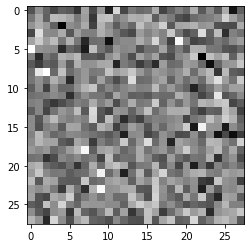

In [23]:
import matplotlib.pyplot as plt
dictionary2 = d2.components_
print()
representation_vec = d.transform(x_train[1:2,:])
print(representation_vec.shape)
print(dictionary.shape)
dictionary = np.transpose(dictionary)
representation_vec = np.transpose(representation_vec)
ans = np.matmul(dictionary,representation_vec)

plt.figure()
plt.imshow(ans.reshape((img_rows, img_cols)), cmap='gray')




In [22]:
import matplotlib.pyplot as plt
representation_vec = d2.transform(x_train[1:2,:])
print(representation_vec.shape)
print(dictionary2.shape)
dictionary2 = np.transpose(dictionary2)
representation_vec = np.transpose(representation_vec)
ans = np.matmul(dictionary2,representation_vec)

plt.figure()
plt.imshow(ans.reshape((img_rows, img_cols)), cmap='gray')


(1, 784)


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_dict_learning.py:177: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


NameError: ignored

creating gan:

In [0]:
# generator:
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization

# input: image size
# output: noise size
def create_reconstructor():
    reconstructor = Sequential()

    reconstructor.add(Dense(512, input_dim=img_cols*img_rows*channels))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(256))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(noise_dim))
    reconstructor.add(LeakyReLU(0.2))

    #reconstructor.compile(loss='mean_squared_error', optimizer='sgd')
    return reconstructor

# input: noise size
# output: image size
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    # remove this to return to FC scheme
    generator.add(Reshape((img_rows, img_cols, channels)))
    #generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_descriminator():
    discriminator = Sequential()
    #16 - better
    discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    #32 - better
    discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    # 64 - better
    discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))   # 1 number which indicates real / fake
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator
    
"""
def create_descriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator
"""
# build GAN
discriminator = create_descriminator()
generator = create_generator()
reconstructor = create_reconstructor()

discriminator.trainable = False   # will be trained separately, not as GAN

gan_input = Input(shape=(noise_dim,))

fake_image = generator(gan_input)

fake_image_vec = Flatten()(fake_image)  # will enter reconstructor


gan_output = discriminator(fake_image)

vae_output = reconstructor(fake_image_vec)

vae = Model(gan_input, vae_output)
vae.compile(loss='mean_squared_error', optimizer='sgd') #todo: consider MAE

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


train the GAN:

(None, 784)
(None, 100)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 	 Discriminator Loss: 0.24623315036296844 		 Generator Loss: 3.267835855484009 		 Reconstructor Loss: 0.9457851648330688 
Epoch: 1 	 Discriminator Loss: 0.2589292526245117 		 Generator Loss: 3.885723829269409 		 Reconstructor Loss: 0.9594258069992065 
Epoch: 2 	 Discriminator Loss: 0.23936159908771515 		 Generator Loss: 3.946578025817871 		 Reconstructor Loss: 1.0347537994384766 
Epoch: 3 	 Discriminator Loss: 0.21601106226444244 		 Generator Loss: 5.366122722625732 		 Reconstructor Loss: 1.0479507446289062 
Epoch: 4 	 Discriminator Loss: 0.26192808151245117 		 Generator Loss: 4.450636386871338 		 Reconstructor Loss: 1.0151227712631226 
Epoch: 5 	 Discriminator Loss: 0.2654881477355957 		 Generator Loss: 3.3728604316711426 		 Reconstructor Loss: 0.9949914216995239 
Epoch: 6 	 Discriminator Loss: 0.21870771050453186 		 Generator Loss: 3.5679547786712646 		 Reconstructor Loss: 1.0137231349945068 
Epoch: 7 	 Discriminator Loss: 0.33633220195770264 		 Generator Loss: 4.90957164764

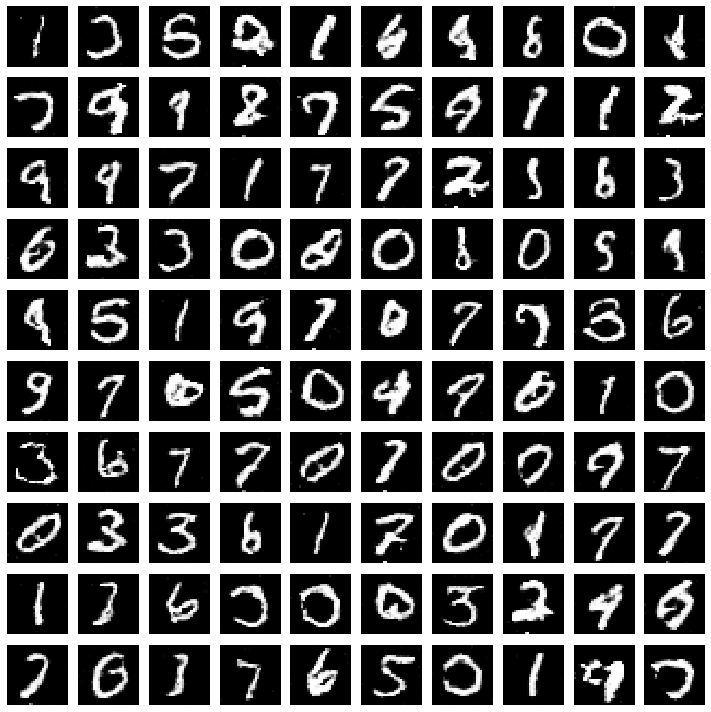

In [0]:
import matplotlib.pyplot as plt


for epoch in range(epochs):  
    for batch in range(steps_per_epoch): 
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        fake_x = generator.predict(noise) # create G(z)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)] # sample real image
        #remove below to return to FC scheme
        real_x = real_x.reshape(fake_x.shape)

        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        # train_on_batch recieves data and desired output
        d_loss_fake = discriminator.train_on_batch(x[:batch_size], disc_y[:batch_size])
        d_loss_real = discriminator.train_on_batch(x[batch_size:-1], disc_y[batch_size:-1])
        # train GAN (descriminator weights are fixed)
        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)
        # train reconstructor
        if(batch)
          r_loss = vae.train_on_batch(noise[:batch_size],noise[:batch_size])

        

    print(f'Epoch: {epoch} \t Discriminator Loss: {(d_loss_fake+d_loss_real)/2} \t\t Generator Loss: {g_loss} \t\t Reconstructor Loss: {r_loss} ')


def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)





view results:

In [0]:
import matplotlib.pyplot as plt

def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)

NameError: ignored